# DLMRA Code
-------------------

# Approximate Nearest Neighbors Search of Euclidean Vectors

In this session, we will explore Approximate Nearest Neighbor (ANN) search for the real-valued vectors. This is a very common scenario as the majority of media representations are extracted by deep learning methods producting real-valued vectors and compared with Euclidean distance/cosine similarity.

We will:

*   preprocess real-valued vector to facilitate indexing;
*   index real-valued vectors using quantization techniques implemented in the FAISS library;
*   index real-valued vectors using surrogate text representations.


## Getting Started

Let's install the [FAISS](https://) library and import needed packages.

In [ ]:
!pip install -q faiss-cpu

     |████████████████████████████████| 8.4MB 5.1MB/s 


In [ ]:
import faiss
import h5py
import math
import numpy as np
import pandas as pd
import seaborn as sns
import time

from tqdm.auto import tqdm

In [ ]:
!pip install -q ipython-autotime
%load_ext autotime

time: 310 µs (started: 2021-06-04 13:52:53 +00:00)


Next, we get some data to index. We will use the GloVe word embedding dataset provided by [ann-benchmarks.com](https://github.com/erikbern/ann-benchmarks/#data-sets). It's a dataset of 1M+ word embeddings that also provides 10k queries for which true nearest neighbors are already computed. Vectors are compared with the cosine similarity.

In [ ]:
!wget --no-clobber http://ann-benchmarks.com/glove-100-angular.hdf5

--2021-06-04 13:52:53--  http://ann-benchmarks.com/glove-100-angular.hdf5
Resolving ann-benchmarks.com (ann-benchmarks.com)... 52.216.110.218
Connecting to ann-benchmarks.com (ann-benchmarks.com)|52.216.110.218|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 485413888 (463M) [binary/octet-stream]
Saving to: ‘glove-100-angular.hdf5’

glove-100-angular.h 100%[===================>] 462.93M  57.2MB/s    in 7.4s    

2021-06-04 13:53:00 (63.0 MB/s) - ‘glove-100-angular.hdf5’ saved [485413888/485413888]

time: 7.68 s (started: 2021-06-04 13:52:53 +00:00)


The dataset is in HDF5 format, a popular scientific format that can be accessed using the `h5py` library. Let's see what's inside the datset file.

In [ ]:
data = h5py.File('glove-100-angular.hdf5', 'r')  # open in read mode
list(data.items())

[('distances', <HDF5 dataset "distances": shape (10000, 100), type "<f4">),
 ('neighbors', <HDF5 dataset "neighbors": shape (10000, 100), type "<i4">),
 ('test', <HDF5 dataset "test": shape (10000, 100), type "<f4">),
 ('train', <HDF5 dataset "train": shape (1183514, 100), type "<f4">)]

time: 25.3 ms (started: 2021-06-04 13:53:00 +00:00)


In [ ]:
# data can be accessed as numpy arrays
data['train'][0]

array([-0.11333  ,  0.48402  ,  0.090771 , -0.22439  ,  0.034206 ,
       -0.55831  ,  0.041849 , -0.53573  ,  0.18809  , -0.58722  ,
        0.015313 , -0.014555 ,  0.80842  , -0.038519 ,  0.75348  ,
        0.70502  , -0.17863  ,  0.3222   ,  0.67575  ,  0.67198  ,
        0.26044  ,  0.4187   , -0.34122  ,  0.2286   , -0.53529  ,
        1.2582   , -0.091543 ,  0.19716  , -0.037454 , -0.3336   ,
        0.31399  ,  0.36488  ,  0.71263  ,  0.1307   , -0.24654  ,
       -0.52445  , -0.036091 ,  0.55068  ,  0.10017  ,  0.48095  ,
        0.71104  , -0.053462 ,  0.22325  ,  0.30917  , -0.39926  ,
        0.036634 , -0.35431  , -0.42795  ,  0.46444  ,  0.25586  ,
        0.68257  , -0.20821  ,  0.38433  ,  0.055773 , -0.2539   ,
       -0.20804  ,  0.52522  , -0.11399  , -0.3253   , -0.44104  ,
        0.17528  ,  0.62255  ,  0.50237  , -0.7607   , -0.071786 ,
        0.0080131, -0.13286  ,  0.50097  ,  0.18824  , -0.54722  ,
       -0.42664  ,  0.4292   ,  0.14877  , -0.0072514, -0.1648

time: 12.6 ms (started: 2021-06-04 13:53:00 +00:00)


Since we have the groundtruth provided by the dataset, we will compute the **Recall** as metric of quality of the results retrieved by the indices we will use.

In [ ]:
def compute_recall(true_neighbors, predicted_neighbors):
  recalls = []
  for t, p in zip(true_neighbors, predicted_neighbors):
    intersection = np.intersect1d(t, p)
    recall = len(intersection) / len(t)
    recalls.append(recall)

  return np.mean(recalls)

time: 4.97 ms (started: 2021-06-04 13:53:00 +00:00)


## Preparing the Vectors for Indexing

Accessing h5py datasets returns numpy arrays containing the part you requested. Let's load the whole dataset in RAM.

**NOTE**: you might not be able to load the whole dataset at once; in that case you should load, process, and index your dataset in manageable batches.

In [ ]:
x = data['train'][:]
q = data['test'][:]

true_neighbors = data['neighbors'][:]

d = q.shape[1]  # n. of columns = n. of dimensions
print(x.shape)
print(q.shape)

(1183514, 100)
(10000, 100)
time: 225 ms (started: 2021-06-04 13:53:00 +00:00)


### Dimensionality Reduction

A preliminar operation you might want to do is to apply Principal Component Analysis (PCA) to reduce the dimensionality of your vectors. Ideally, you want the smallest vectors that still are able to capture differences in your data using the metric you are using ($L_2$ or $\cos$).

The right number of dimensions depends on the dataset and is often chosen empirically.

In [ ]:
from sklearn.decomposition import PCA

# n_components = 25  # <-- you can choose how many dimensions to keep, or...
n_components = 'mle' # ... use Maximum Likelihood Estimation to guess the optimal n_components
pca = PCA(n_components=n_components)
pca.fit(x)
pca.n_components_
# x = pca.transform(x)
# q = pca.transform(q)

99

time: 14 s (started: 2021-06-04 13:53:01 +00:00)


### L2 Normalization

If you are interested in the cosine similarity (often it's the case), another useful preprocessing is $L_2$ normalization of vectors. When operating on normalized spaces,
the Euclidean distance, the cosine similarity, and the inner product are related to each other and provide the same ranking of nearest neighbors.
This also permits us to use solutions implementing one of the above metrics interchangeably.


$||A-B||_2^2 = ||A||_2^2 + ||B||_2^2 - 2 A \cdot B \qquad \xrightarrow{||A||_2^2 = ||B||_2^2 = 1} \qquad ||A-B||_2^2 = 2 - 2cos(A,B)$



In [ ]:
from sklearn.preprocessing import normalize

x = normalize(x)  # apply L2 normalization
q = normalize(q)

time: 358 ms (started: 2021-06-04 13:53:15 +00:00)


Let's see all the techniques you can use to solve queries on vector data depending on the size of the dataset and the resources (computing, time) you can allocate. 

## Sequential Search / Bruteforce

If your dataset is small enough, a bruce force search might be sufficient, but beware:

In [ ]:
# computing the complete distance matrix using efficient matrix multiplication

# D = q.dot(x.T) #  unfeasible!
# or
# D = cdist(q, x, metric='euclidean')
# I = D.argsort(axis=1)
giga = len(q) * len(x) * 4 / (1000 * 1000 * 1000)
print(f'{giga} GB!')

47.34056 GB!
time: 3.48 ms (started: 2021-06-04 13:53:15 +00:00)


Let's see how it works on a subset of the queries:

In [ ]:
n_queries = 100  # we perform the first 100 queries
k = 100  # we want the 100 nearest neighbors

q = q[:n_queries]
true_neighbors = true_neighbors[:n_queries]

time: 2.5 ms (started: 2021-06-04 13:53:15 +00:00)


In [ ]:
# let's try on a subset of queries
sim_matrix = q.dot(x.T)  # compute the cosine similarity matrix btw queries and dataset
I = sim_matrix.argsort(axis=1)[:, ::-1][:, :k]  # sort each row, get the k indexes with highest scores
D = sim_matrix[np.arange(n_queries).reshape(-1, 1), I]  # get the corresponding scores

time: 17 s (started: 2021-06-04 13:53:15 +00:00)


In [ ]:
recall = compute_recall(true_neighbors, I)
print(recall)

1.0
time: 12.3 ms (started: 2021-06-04 13:53:32 +00:00)


An equivalent (but more efficient) implementation of a sequential search is provided by FAISS with the `IndexFlatL2` class.

In [ ]:
index = faiss.IndexFlatL2(d)
index.add(x)

time: 382 ms (started: 2021-06-04 13:53:32 +00:00)


In [ ]:
Df, If = index.search(q, k)
print(Df)
print(If)

[[0.8607881  0.86477077 0.86618185 ... 0.97620094 0.9763502  0.97651803]
 [0.7170136  0.7370894  0.77280223 ... 0.8804196  0.88081217 0.8809656 ]
 [0.72514653 0.7722744  0.7909728  ... 0.9684732  0.9690821  0.9695796 ]
 ...
 [0.72944987 0.735113   0.7630491  ... 0.9676869  0.9690497  0.96907663]
 [0.30982244 0.92508125 0.93053544 ... 1.1048784  1.1058317  1.1062746 ]
 [0.5971943  0.60940814 0.6094276  ... 0.78186893 0.78189135 0.7822877 ]]
[[  97478  262700  846101 ...  598329  944409  725625]
 [ 875925  903728  144313 ...  857806  543125  973672]
 [1046944  809599  531832 ...  821775  340919  685590]
 ...
 [  35444  686047  782541 ...  624884  413253 1147028]
 [1122395  678011      45 ...  187958  526213  743497]
 [ 778692 1130001  938567 ...  821752   87923  835651]]
time: 1.02 s (started: 2021-06-04 13:53:32 +00:00)


In [ ]:
check = np.allclose(Df, 2 - 2*D)  # L2^2 == 2 - 2*cosine
print(check)

True
time: 3 ms (started: 2021-06-04 13:53:33 +00:00)


The main drawbacks of sequential search is that all the dataset must be accessed.

## Voronoi Partitioning with Inverted Files (FAISS)

To reduce the number of data samples accessed to respond to a query, we can partition the data using [Voronoi partitioning](https://en.wikipedia.org/wiki/Voronoi_diagram). We perform k-means on the dataset and store the data samples in an inverted file such that each cluster has its own posting list. This can be done in FAISS with the `IndexIVFFlat` class.


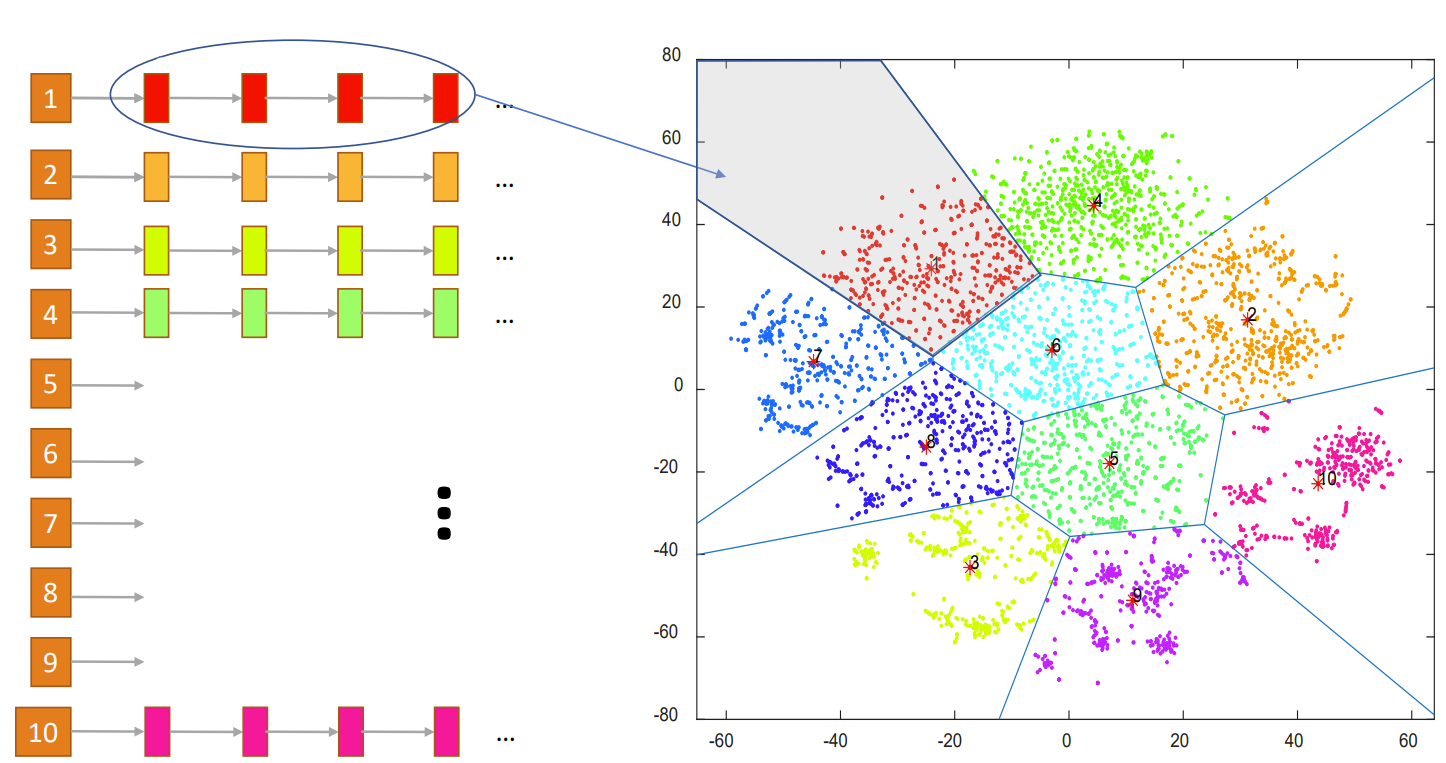

In [ ]:
nlist = 100  # number of posting lists = number of clusters in k-means

quantizer = faiss.IndexFlatL2(d)  # this is the index that will contain the
                                  # clusters and will be used to search the
                                  # nearest centroids

index = faiss.IndexIVFFlat(quantizer, d, nlist)
index.train(x)  # this index must be trained (run k-means) to be used
print(index.is_trained)

index.add(x)  # now we can add the data

True
time: 1.89 s (started: 2021-06-04 13:53:33 +00:00)


At query time, we access the posting lists associated with the `nprobe` nearest centroids to the query.

In [ ]:
index.nprobe = 1
D, I = index.search(q, k)
recall = compute_recall(true_neighbors, I)
print(recall)

0.46830000000000005
time: 126 ms (started: 2021-06-04 13:53:35 +00:00)


Let's search the parameter space to find good operational points.

## Quantizing Vectors (FAISS)

The IVFFlat index still needs to store the entire dataset of vectors to respond to queries.
If space is a concern (either storing the index in RAM or Disk), vectors can be compressed into compact representations using a **quantization** technique.
Once a codebook is built (e.g. with k-means), a vector can be represented compactly by the index of a code word in the codebook; however, this will introduce a quantization error.

### Scalar Quantization

Scalar Quantization is the simplest type of quantization. Each value of the vector is encoded with the index of the nearest centroid found with a 1D k-means.
Commonly used codebooks have indices of 4 bits (16 centroids), 6 bits (64 cetroids), or 8 bits (256 centroids).

In [ ]:
quantizer = faiss.IndexScalarQuantizer(d, faiss.ScalarQuantizer.QT_8bit)
quantizer.train(x)

time: 199 ms (started: 2021-05-31 16:23:44 +00:00)


In [ ]:
code_size = quantizer.sa_code_size()
print(f'After quantization, each vector will occupy {code_size} bytes (instead of {4*d}); space is reduced by a factor {(4*d / code_size):g}.')

After quantization, each vector will occupy 100 bytes (instead of 400); space is reduced by a factor 4.
time: 1.58 ms (started: 2021-05-31 16:23:44 +00:00)


In [ ]:
encoded = quantizer.sa_encode(x[:5])
encoded

array([[122, 157, 132, 116, 131,  92, 124,  89, 141,  92, 129, 131, 190,
        121, 179, 180, 106, 144, 162, 171, 142, 155, 105, 145, 105, 210,
        121, 140, 132, 100, 131, 149, 165, 141, 120,  92, 118, 167, 130,
        164, 168, 123, 136, 151, 110, 127, 103,  92, 149, 138, 165, 114,
        164, 135, 114, 116, 156, 122, 108, 100, 132, 162, 170,  63, 121,
        117, 119, 163, 132,  87, 106, 152, 132, 133, 112, 117, 189,  77,
        130, 153, 107, 112, 150, 137, 105, 148, 146, 131, 171, 120, 107,
        166, 111, 135,  91, 125, 133, 175, 120, 114],
       [ 92,  40, 116,  94, 144,  87, 115,  64, 146, 121, 127, 145, 192,
        176, 139, 131,  90, 140, 161, 156, 117, 104, 143, 119, 102, 176,
        133,  81, 196, 151, 112, 107, 123, 126, 150, 143, 158, 117, 104,
        160, 134, 178, 138, 114,  99, 115,  99, 155, 105, 140, 124, 109,
        174, 150, 176, 159, 169, 113, 124, 162, 106,  92, 144, 181, 167,
         92, 127, 133, 111, 125, 116,  84, 143, 124, 138, 152, 120, 17

time: 9.52 ms (started: 2021-05-31 16:23:49 +00:00)


In [ ]:
decoded = quantizer.sa_decode(encoded)
error = (x[:5] - decoded)
error.mean(), error.std()

(2.8341822e-07, 0.0010319514)

time: 11.7 ms (started: 2021-05-31 16:23:53 +00:00)


In FAISS, quantizers can be used as bruteforce indices that perform sequential scan using the decoded vectors. This can be useful for evaluating the performance of the approximation introduced by the quantization.

In [ ]:
quantizer.add(x)  # adding data encodes it using the quantizer
D, I = quantizer.search(q, k)
recall = compute_recall(true_neighbors, I)
print(recall)

0.9843000000000002
time: 25.7 s (started: 2021-05-31 16:24:03 +00:00)


### Product Quantization

Product Quantization can achieve higher compression factors. In PQ, vectors are divided in chunks (sub-vectors) that are encoded with the index in a codebook.
The codebook is found by k-means over sub-vectors and is often shared between all chunks (a single codebook is used for all the chunks of the vector).

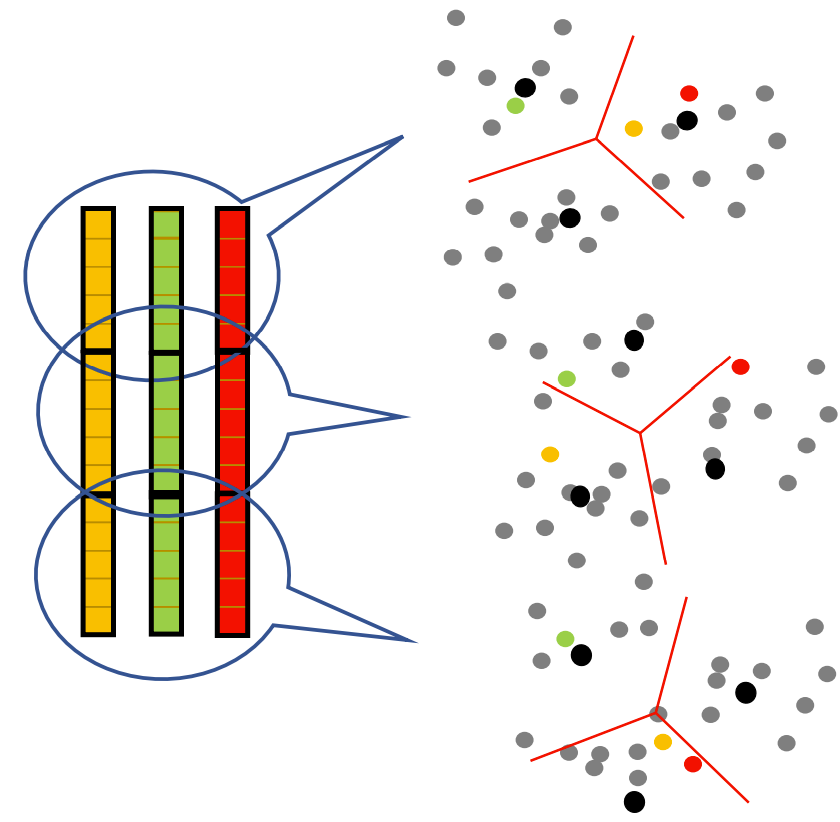

In [ ]:
code_size = 20   # = number of chucks the vector is divided into
n_bits = 8  # each chunk is coded with this number of bits, usually 8 (1 byte, 256 centroids) or 16 (2 bytes, 65536 centroids)

quantizer = faiss.IndexPQ(d, code_size, n_bits)
quantizer.train(x[:10_000])  # we train on a subset for speeding up the process

time: 5.37 s (started: 2021-05-31 16:24:36 +00:00)


In [ ]:
code_size = quantizer.sa_code_size()
print(f'After quantization, each vector will occupy {code_size} bytes (instead of {4*d}); space is reduced by a factor {(4*d / code_size):g}.')

After quantization, each vector will occupy 20 bytes (instead of 400); space is reduced by a factor 20.
time: 6.03 ms (started: 2021-05-31 16:24:41 +00:00)


In [ ]:
encoded = quantizer.sa_encode(x[:5])
print(encoded.shape)

(5, 20)
time: 4.44 ms (started: 2021-05-31 16:24:41 +00:00)


In [ ]:
decoded = quantizer.sa_decode(encoded)
error = (x[:5] - decoded)
print(error.mean(), error.std())

-0.00011106366 0.03542932
time: 6.15 ms (started: 2021-05-31 16:24:50 +00:00)


As for the Scalar Quantizater, let's use the product quantizer we built as a bruteforce index to evaluate the approximation introduced.

In [ ]:
quantizer.add(x)  # adding data encodes it using the quantizer
D, I = quantizer.search(q, k)
recall = compute_recall(true_neighbors, I)
print(recall)

0.49159999999999987
time: 27.7 s (started: 2021-05-31 16:25:00 +00:00)


## IVFADC: Partitioning + Quantization (FAISS)

We can get fast and compact indices combining partitioning with quantization. An example is the Inverted File with Asymmetric Distance Computation (IVFADC) index, that combines Voronoi partitioning and Product Quantization, and is implemented by the _IndexIVFPQ_ class in FAISS.

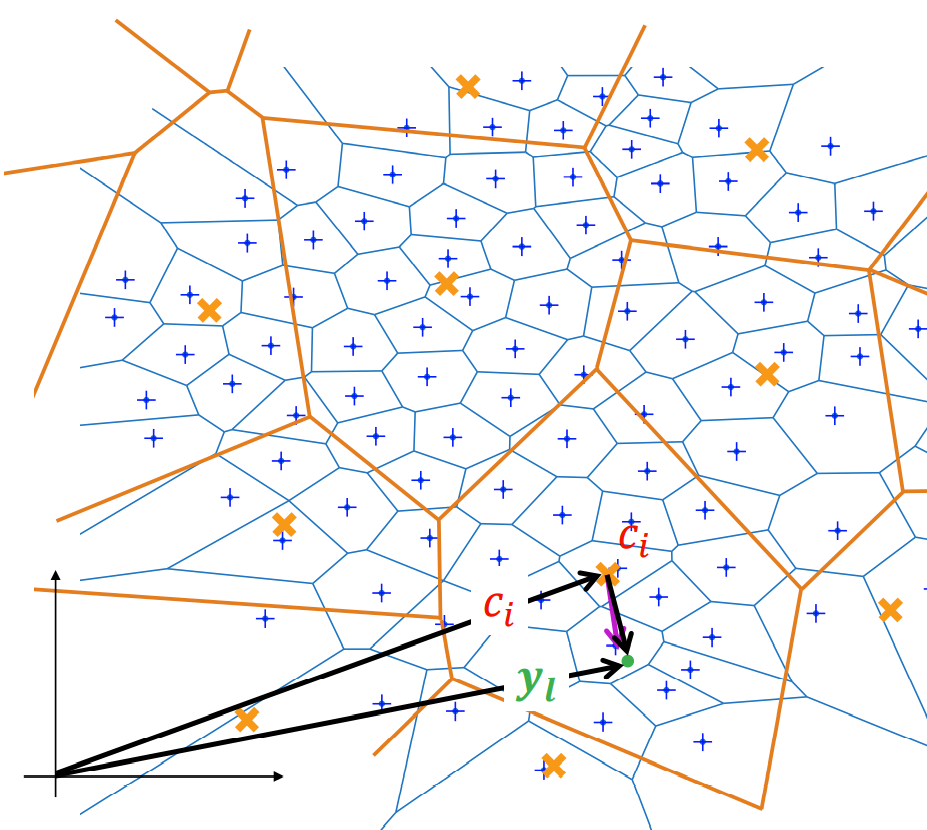

In [ ]:
nlist = int(4 * math.sqrt(len(x)))  # number of partitions of the coarse quantizer = number of posting lists
code_size = 50  # = number of subquantizers = number of sub-vectors
n_bits = 8  # n_bits of each code (8 -> 1 byte codes)

coarse_quantizer = faiss.IndexFlatL2(d)  # will keep centroids of coarse quantizer (for inverted list)
index = faiss.IndexIVFPQ(coarse_quantizer, d, nlist, code_size, n_bits)

# train() runs both the k-means for the coarse (samples partitioning) and the fine (PQ) quantizers.
index.train(x[:10_000])  # train on a random subset to speed up k-means (NOTE: ensure they are randomly chosen!)
index.add(x)

time: 1min 32s (started: 2021-05-31 17:11:38 +00:00)


In [ ]:
index.nprobe = 50  # number of lists accessed (the nearest to the query)
D, I = index.search(q, k)

time: 501 ms (started: 2021-05-31 17:15:29 +00:00)


In [ ]:
recall = compute_recall(true_neighbors, I)
print(recall)

0.7305999999999999
time: 11 ms (started: 2021-05-31 17:15:30 +00:00)


## Additional Resources

*   https://ai.facebook.com/tools/faiss/
*   https://github.com/facebookresearch/faiss/wiki/
*   https://github.com/erikbern/ann-benchmarks/
*   http://melisandre.deepfeatures.org/
